<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/DGRNet%20STEP3-%20Daily%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

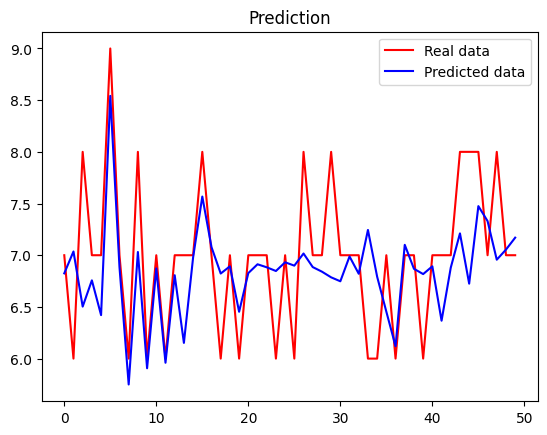

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import scipy.stats as stats
import pylab as pl

generator_multiply = 50 #each input record will generate 100 random vectors from the latent space, given the mu and sigma generated by the encoder

#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')



#get data
train_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TRAIN-Daily-May2024.npy')




#window_label = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences_WINDOW-Daily-May2024.npy')
#window_label = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences_WINDOW-Daily-May2024.npy')

n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]

#----------------check window distribution - we see upto 20 has very high fequency. so we remove that and take the rest to generate more samples, to create overall uniform distribution...
#First we test window 20 to 30 and see if this method can fit the model well

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(window_label, kde=True, color="red")
plt.subplot(1,2,2)



##---------------------------IGNORE THIS IF NOT GENERATING FRESH VAE DATASET--------------------------------------------------------------------------------------------

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-encoder-saved-round4-latent5-dim256.model')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-decoder-saved-round4-latent5-dim256.model')

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]  #number of recors / batchs
dim = tf.shape(mu)[1] #Ndimension of latent variable
store = list()
storetemp = list()


#For each batch, iterate, get the generator_multipy number of latent vectors with same window_size.
#For each z, concatenate z_mean, so it will become 100 dimensional vector

for i in range(0,batch):
  all_Z_i = tf.random.normal(shape=(generator_multiply,dim), mean = mu[i,:], stddev=sigma[i,:]) #all randorm vectors for this record i
  X_train_decoded = decoder.predict(all_Z_i)
  X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0],window_size*n_features))
  a = np.arange(generator_multiply)
  a.fill(window_label[i])
  c=np.concatenate(((X_train_decoded,a[:,None])),axis=1)
  store.append(c)

results1=np.concatenate(store,axis=0)
np.save(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_daily_x50',results1)


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

results1=np.load(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_daily_x50.npy')

x=results1[:,:-1]
y=results1[:,window_size*n_features]

#--------------------------------------IF REQUIRED REMOVE outlier....however we are not doing this now.--------------------------------------------------------------------------------------------------------------------------------------
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.4)
yhat = iso.fit_predict(x)
# select all rows that are not outliers
mask = yhat != -1
x, y = x[mask, :], y[mask]


###############Scale the target and then split the data into train test----------------------------------------------------------------------------------------------------------------------------------



#Looking at the dist, we remove al y less than 20
from sklearn.preprocessing import PowerTransformer
transformer = StandardScaler()

y_transformed = transformer.fit_transform(y.reshape(-1,1)).flatten()

x_train, x_test, y_train, y_test = train_test_split(x, y_transformed, test_size = 0.1, random_state = 42)

#--------------------------------------------------------------------------------------CONSTRUCT, COMPILE, AND TRAIN THE MODEL------------------------------------------------------------------------------------------------------------------
#------------MLP------------------------------------------------------
#x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
#x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
from keras.layers import LeakyReLU

model = Sequential()
#model.add(LSTM(1024, input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(512,return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(units = 1024))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 512))
#model.add(LeakyReLU(alpha=0.1))


model.add(Dense(units = 128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 32))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 1))
#--------------------------------------------------------------LSTM--------------------------

a =  x_train.reshape((x_train.shape[0], window_size, n_features))  #DONT RUN IF MLP
b =  x_test.reshape((x_test.shape[0], window_size, n_features))    #DONT RUN IF MLP

from keras.layers import LeakyReLU
model = Sequential()
model.add(LSTM(32, input_shape=(a.shape[1],a.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dropout(0.2))
#model.add(Dense(units = 1024))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 512))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 512))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 256))
#model.add(LeakyReLU(alpha=0.1))

model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.3))
#model.add(Dense(units = 16))
#model.add(LeakyReLU(alpha=0.01))

#model.add(Dense(units = 4))
#model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units = 1, activation = 'linear'))
model.summary()
x_train = a
x_test = b
#-------------------------------------------------------------------------------------


#sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizr = keras.optimizers.Adam(learning_rate=0.0005,clipnorm=1)
model.compile(loss='mean_squared_error', optimizer= optimizr, metrics=['mean_squared_error'])

es = keras.callbacks.EarlyStopping(patience=20, verbose=1, min_delta=0.0001, monitor='loss', mode='min', restore_best_weights=True)
n_epochs = 1000

history=model.fit( x_train,y_train,
                 epochs=n_epochs,
                 batch_size=32,
                   validation_split=0.1)
                 #callbacks=[es])


#-------------------------LOSS-------------------------------------
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#-----------------------------------------------------TRAIN EVALUATION----------------------------------------------------------------
y_train_pred_raw = model.predict(x_train)
y_train_pred = transformer.inverse_transform(y_train_pred_raw)
y_train_true = transformer.inverse_transform(y_train.reshape(-1,1)).flatten()

score_train= r2_score(y_train_true,y_train_pred)
print("r2 score is ==",score_train)

plt.plot(y_train_true[0:100], color = 'red', label = 'Real data')
plt.plot(y_train_pred[0:100], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


#-----------------------------------------------------TEST EVALUATION----------------------------------------------------------------

y_pred_raw = model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1,1)).flatten()



score= r2_score(y_test_true,y_test_pred)
print("r2 score is ==",score)


plt.plot(y_test_true[100:200], color = 'red', label = 'Real data')
plt.plot(y_test_pred[100:200], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#------------------------------------------------------SAVE MODEL AND RESULTS-----------------------------------------------------------------

model.save(r'/content/drive/MyDrive/PHD/2024/DGRNet-MLP-Versions/MLP_model_Daily_V3.keras')
# It can be used to reconstruct the model identically.

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#------------------------------------------------------Retrieve Model-----------------------------------------------------------------

reconstructed_model = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/DGRNet-MLP-Versions/MLP_model_Daily_V3.keras')

#-----------------------------------------------------Test with retrieved model-----------------------------------------------------------------

y_pred_raw = reconstructed_model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1,1)).flatten()

score= r2_score(y_test_true,y_test_pred)
print("r2 score is ==",score)


plt.plot(y_test_true[1000:1050], color = 'red', label = 'Real data')
plt.plot(y_test_pred[1000:1050], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/predicted_window_V3.csv',y_test_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/derived_window_label_V3.csv',y_test_true)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/test_data.csv_V3',x_test)

#--------------------------NOW RUN THE WHOLE DATASET-----------------------------------------------------------------

x_whole = x
y_whole = y_transformed

y_pred_raw_w = reconstructed_model.predict(x_whole)
y_whole_pred = transformer.inverse_transform(y_pred_raw_w)
y_whole_true = transformer.inverse_transform(y_whole.reshape(-1,1)).flatten()

score= r2_score(y_whole_true,y_whole_pred)
print("r2 score is ==",score)


plt.plot(y_whole_true[5000:10000], color = 'red', label = 'Real data')
plt.plot(y_whole_pred[5000:10000], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/predicted_COSW.csv_V3',y_whole_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/Calculated_label_COSW_V3.csv',y_whole_true)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/whole_data_V3.csv',x_whole)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')